This tutorial shows how a simple time series simulation with optimal power flow is performed with the timeseries and control module in pandapower. 

In [12]:
import pandapower as pp
import numpy as np
import os
import pandas as pd
import tempfile
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl


1. create a simple test net
2. create the datasource (which contains the time series P values)
3. create the controllers to update the P values of the load and the sgen
4. define the output writer and desired variables to be saved
5. call the main time series function with optimal power flow to calculate the desired results

We created a simple network and set the constraints and the cost factors into the pandapower element tablesto have the optimal power flow.

In [13]:
def simple_test_net():
    net = pp.create_empty_network()

    b0 = pp.create_bus(net, 110,min_vm_pu=0.98, max_vm_pu=1.05)
    b1 = pp.create_bus(net, 20,min_vm_pu=0.98, max_vm_pu=1.05)
    b2 = pp.create_bus(net, 20,min_vm_pu=0.98, max_vm_pu=1.05)
    b3 = pp.create_bus(net, 20,min_vm_pu=0.9, max_vm_pu=1.05)
    
    e=pp.create_ext_grid(net, b0,min_p_mw=-200, max_p_mw=200)
    costeg = pp.create_poly_cost(net,e ,'ext_grid', cp1_eur_per_mw=10)
    
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0",max_loading_percent=80)
    pp.create_line(net, b1, b2, 10, "149-AL1/24-ST1A 110.0",max_loading_percent=80)
    pp.create_line(net, b1, b3, 10, "149-AL1/24-ST1A 110.0",max_loading_percent=80)

    pp.create_load(net, b3, p_mw=10., q_mvar=-5., name='load1', controllable=False)
    g1=pp.create_sgen(net, b2, p_mw=0., q_mvar=-2,min_p_mw=0, max_p_mw=30,min_q_mvar=-3, max_q_mvar=3, name='sgen1', controllable=True)
    pp.create_poly_cost(net, g1, 'sgen1', cp1_eur_per_mw=-1)
    
    return net


We created the datasource (which contains the time series P values) and kept the load datasource less than the sgen as we cannot control the load with opf. Otherwise one of the lines will be overloaded and it will not be controlled with the opf.

In [3]:
def create_data_source(n_timesteps=24):
    profiles = pd.DataFrame()
    profiles['load1_p'] = np.random.random(n_timesteps) * 10.
    profiles['sgen1_p'] = np.random.random(n_timesteps) * 20.

    ds = DFData(profiles)

    return profiles, ds

We created the controllers to update the P values of the load and the sgen


In [4]:
def create_controllers(net, ds):
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load1_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen1_p"])

Instead of saving the whole net (which takes a lot of time), we extract only pre defined outputs.The variables of create_output_writer are saved to the harddisk after / during the time series loop


In [14]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

Lets run the code

In [15]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
net = simple_test_net()
# create (random) data source
n_timesteps = 24
profiles, ds = create_data_source(n_timesteps)
# create controllers (to control P values of the load and the sgen)
create_controllers(net, ds)
# time steps to be calculated. Could also be a list with non-consecutive time steps
time_steps = range(0, n_timesteps)

#  the output writer with the desired results to be stored to files.
ow = create_output_writer(net, time_steps, output_dir=output_dir)

# 5. the main time series function with optimal power flow
run_timeseries(net, time_steps, run=pp.runopp)

Results can be found in your local temp folder: C:\Users\ssnigdha\AppData\Local\Temp\time_series_example
Progress: |██████████████████████████████████████████████████| 100.0% Complete



We can see that all of the bus voltages are in the defined constraint range according to the optimal power flow.

In [8]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar,lam_p,lam_q
0,1.000000,0.000000,10.269032,2.637892,1.000000e+01,-2.550282e-22
1,1.002489,0.176223,0.000000,0.000000,9.960797e+00,-2.159780e-02
2,1.050000,7.991946,-13.660855,0.649023,-5.785680e-07,-7.235822e-06
3,1.039485,-2.519331,2.412557,-5.000000,1.018861e+01,-4.426233e-01


The loading_percent of the lines are also below 80% as defined the constraints for optimal power flow.

In [9]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,-10.269032,-2.637892,10.286919,2.342249,0.017887,-0.295643,0.055648,0.303802,0.303802,1.000000,0.000000,1.002489,0.176223,64.638751
1,-12.838081,2.376287,13.660855,-0.649023,0.822773,1.727264,0.375963,0.376000,0.376000,1.002489,0.176223,1.050000,7.991946,79.999963
2,2.551163,-4.718536,-2.412557,5.000000,0.138606,0.281464,0.154462,0.154174,0.154462,1.002489,0.176223,1.039485,-2.519331,32.864327


In [16]:
net.res_sgen

,p_mw,q_mvar
0,13.660272,-0.660962


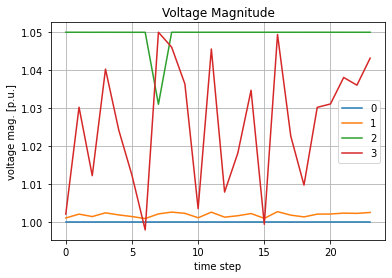

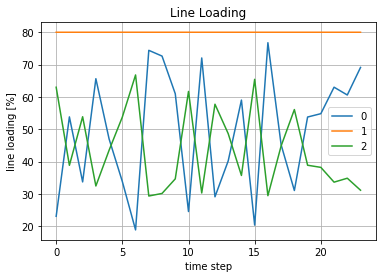

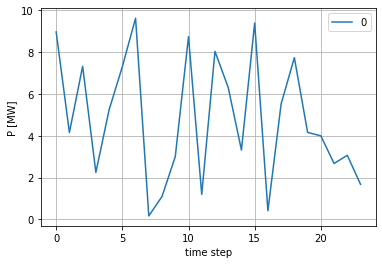

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()